**A lot of the code we have gotten from snntorch https://snntorch.readthedocs.io/en/latest/tutorials/index.html this include diagrams and dataset**


In [313]:
!pip install snntorch

## 1. Setting up the MNIST Dataset

### 1.1. Import packages and setup environment

In [314]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import utils

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import itertools

import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

In [315]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

In [316]:
# Training Parameters
batch_size=128
data_path='/tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float


### 1.2 Download Dataset

In [317]:

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

If the above code block throws an error, e.g. the MNIST servers are down, then uncomment the following code instead.

In [318]:
# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)

Until we actually start training a network, we won't need large datasets.
`snntorch.utils` contains a few useful functions for modifying datasets. Apply `data_subset` to reduce the dataset by the factor defined in `subset`. *E.g., for `subset=10`, a training set of 60,000 will be reduced to 6,000.*


In [319]:



subset = 10
mnist_train = utils.data_subset(mnist_train, subset)
print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 6000


### 1.3 Create DataLoaders
The Dataset objects created above load data into memory, and the DataLoader will serve it up in batches. DataLoaders in PyTorch are a handy interface for passing data into a network. They return an iterator divided up into mini-batches of size ``batch_size``.

In [320]:

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

## 2. Spike Encoding

Spiking Neural Networks (SNNs) are made to exploit time-varying data. And yet, MNIST is not a time-varying dataset.
There are two options for using MNIST with an SNN:

1. Repeatedly pass the same training sample $\mathbf{X}\in\mathbb{R}^{m\times n}$ to the network at each time step. This is like converting MNIST into a static, unchanging video. Each element of $\mathbf{X}$ can take a high precision value normalized between 0 and 1: $X_{ij}\in [0, 1]$.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_1_static.png?raw=true' width="700">
</center>

2. Convert the input into a spike train of sequence length `num_steps`, where each feature/pixel takes on a discrete value $X_{i,j} \in \{0, 1\}$.
In this case, MNIST is converted into a time-varying sequence of spikes that features a relation to the original image.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_2_spikeinput.png?raw=true' width="700">
</center>

The first method is quite straightforward, and does not fully exploit the temporal dynamics of SNNs. So let’s consider data-to-spike conversion (encoding) from (2) in more detail.

The module `snntorch.spikegen` (i.e., spike generation) contains a series of functions that simplify the conversion of data into spikes. There are currently three options available for spike encoding in `snntorch`:

1. Rate coding: [`spikegen.rate`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.rate)
2. Latency coding: [`spikegen.latency`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.latency)
3. Delta modulation: [`spikegen.delta`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.delta)

How do these differ?


1.   *Rate coding* uses input features to determine spiking **frequency**
2.   *Latency coding* uses input features to determine spike **timing**
3.   *Delta modulation* uses the temporal **change** of input features to generate spikes


### 2.1 Rate coding of MNIST

One example of converting input data into a rate code is as follows.
Each normalised input feature $X_{ij}$ is used as the probability an event (spike) occurs at any given time step, returning a rate-coded value $R_{ij}$. This can be treated as a Bernoulli trial: $R_{ij}\sim B(n,p)$, where the number of trials is $n=1$, and the probability of success (spiking) is $p=X_{ij}$. Explicitly, the probability a spike occurs is:

$${\rm P}(R_{ij}=1) = X_{ij} = 1 - {\rm P}(R_{ij} = 0)$$

Create a vector filled with the value '0.5' and encode it using the above technique:

In [321]:
# Temporal Dynamics
num_steps = 10

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"Converted vector: {rate_coded_vector}")

print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Converted vector: tensor([0., 1., 0., 1., 1., 1., 1., 1., 1., 0.])
The output is spiking 70.00% of the time.


Now try again, but increasing the length of `raw_vector`:

In [322]:
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

The output is spiking 54.00% of the time.


As `num_steps`$\rightarrow\infty$, the proportion of spikes approaches the original raw value.

For an MNIST image, this probability of spiking corresponds to the pixel value. A white pixel corresponds to a 100% probability of spiking, and a black pixel will never generate a spike. Take a look at the 'Rate Coding' column below for further intuition.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_3_spikeconv.png?raw=true' width="1000">
</center>

In a similar way, `spikegen.rate` can be used to generate a rate-coded sample of data. As each sample of MNIST is just an image, we can use `num_steps` to repeat it across time.

In [323]:
# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)

If the input falls outside of $[0,1]$, this no longer represents a probability. Such cases are automatically clipped to ensure the feature represents a probability.

The structure of the input data is ``[num_steps x batch_size x input dimensions]``:

In [324]:
print(spike_data.size())

torch.Size([100, 128, 1, 28, 28])


### 2.2 Visualization

#### 2.2.1 Animation
snnTorch contains a module [`snntorch.spikeplot`](https://snntorch.readthedocs.io/en/latest/snntorch.spikeplot.html) that simplifies the process of visualizing, plotting, and animating spiking neurons.


To plot one sample of data, index into a single sample from the batch (B) dimension of `spike_data`, ``[T x B x 1 x 28 x 28]``:

In [325]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


`spikeplot.animator` makes it super simple to animate 2-D data.<br>
Note: if you are running the notebook locally you may need to install ffmpeg: e.g., `pip install ffmpeg` or if in a Conda environment, `conda install -c conda-forge ffmpeg`.<br>
If ffmpeg is not found, please uncomment the line below and modify the path to your ffmpeg.exe.

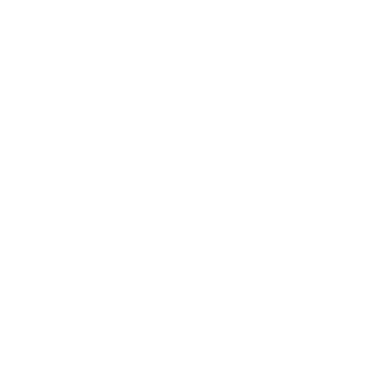

In [326]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

HTML(anim.to_html5_video())

In [327]:
# If you're feeling sentimental, you can save the animation: .gif, .mp4 etc.
anim.save("spike_mnist_test.mp4")

The associated target label can be indexed as follows:

In [328]:
print(f"The corresponding target is: {targets_it[0]}")

The corresponding target is: 6


MNIST features a greyscale image, and the white text guarantees a 100% of spiking at every time step. So let's do that again but reduce the spiking frequency. This can be achieved by setting the argument `gain`. Here, we will reduce spiking frequency to 25%.

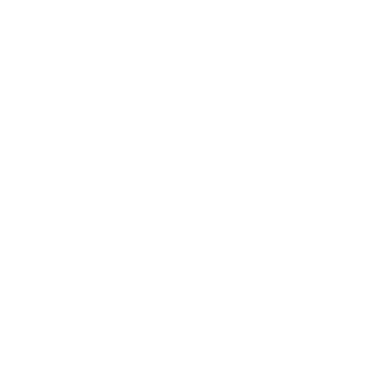

In [402]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

In [330]:
# Uncomment for optional save
# anim.save("spike_mnist_test2.mp4")

Now average the spikes out over time and reconstruct the input images.

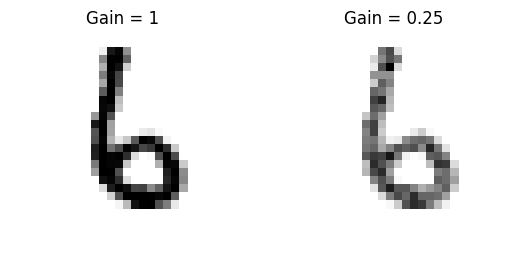

In [331]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

The case where `gain=0.25` is lighter than where `gain=1`, as spiking probability has been reduced by a factor of $\times 4$.

#### 2.2.2 Raster Plots
Alternatively, we can generate a raster plot of an input sample. This requires reshaping the sample into a 2-D tensor, where 'time' is the first dimension. Pass this sample into the function `spikeplot.raster`.

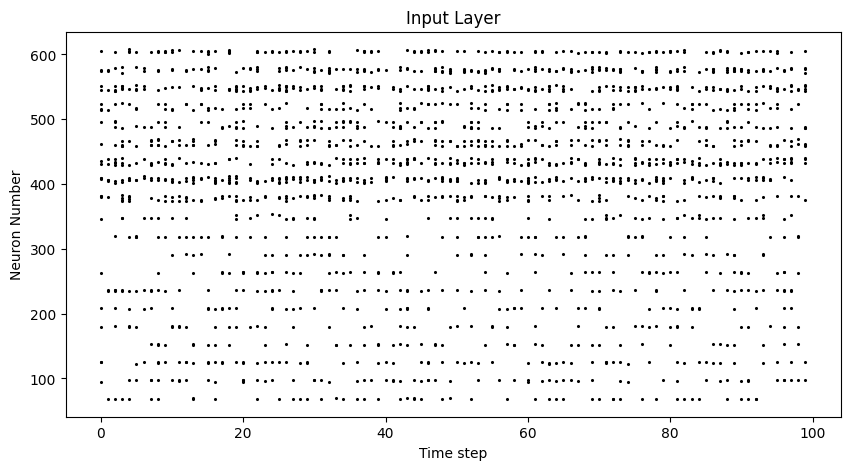

In [332]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

The following code snippet shows how to index into one single neuron.
Depending on the input data, you may need to try
a few different neurons between 0 & 784 before finding one that
spikes.

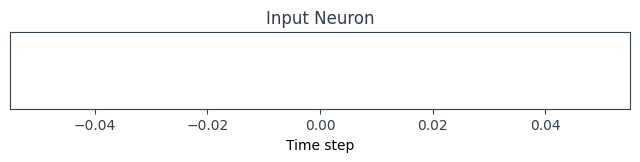

In [401]:
idx = 210  # index into 210th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

#### 2.2.3 Summary of Rate Coding
The idea of rate coding is actually quite controversial. Although we are fairly confident rate coding takes place at our sensory periphery, we are not convinced that the cortex globally encodes information as spike rates. A couple of compelling reasons why include:

*   **Power Consumption:** Nature optimised for efficiency. Multiple spikes are needed to achieve any sort of task, and each spike consumes power. In fact, [Olshausen and Field's work in "What is the other 85% of V1 doing?"](http://www.rctn.org/bruno/papers/V1-chapter.pdf) demonstrates that rate-coding can only explain, at most, the activity of 15% of neurons in the primary visual cortex (V1). It is unlikely to be the only mechanism within the brain, which is both resource-constrained and highly efficient.


*   **Reaction Response Times:** We know that the reaction time of a human is roughly around 250ms. If the average firing rate of a neuron in the human brain is on the order of 10Hz, then we can only process about 2 spikes within our reaction timescale.

So why, then, might we use rate codes if they are not optimal for power efficiency or latency? Even if our brain doesn't process data as a rate, we are fairly sure that our biological sensors do. The power/latency disadvantages are partially offset by showing huge noise robustness: it's fine if some of the spikes fail to generate, because there will be plenty more where they came from.

Additionally, you may have heard of the [Hebbian mantra of "neurons that fire together, wire together"](https://doi.org/10.2307/1418888). If there is plenty of spiking, this may suggest there is plenty of learning. In some cases where training SNNs proves to be challenging, encouraging more firing via a rate code is one possible solution.

Rate coding is almost certainly working in conjunction with other encoding schemes in the brain. We will consider these other encoding mechanisms in the following sections.
This covers the `spikegen.rate` function. Further information [can be found in the documentation here](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html).



### 2.3 Latency Coding of MNIST
Temporal codes capture information about the precise firing time of neurons; a single spike carries much more meaning than in rate codes which rely on firing frequency. While this opens up more susceptibility to noise, it can also decrease the power consumed by the hardware running SNN algorithms by orders of magnitude.

`spikegen.latency` is a function that allows each input to fire at most **once** during the full time sweep.
Features closer to `1` will fire earlier and features closer to `0` will fire later. I.e., in our MNIST case, bright pixels will fire earlier and dark pixels will fire later.

The following block derives how this works. If you've forgotten circuit theory and/or the math means nothing to you, then don't worry! All that matters is: **big** input means **fast** spike; **small** input means **late** spike.


---
**Optional: Derivation of Latency Code Mechanism**

By default, spike timing is calculated by treating the input feature as the current injection $I_{in}$ into an RC circuit. This current moves charge onto the capacitor, which increases $V(t)$. We assume that there is a trigger voltage, $V_{thr}$, which once reached, generates a spike. The question then becomes: *for a given input current (and equivalently, input feature), how long does it take for a spike to be generated?*

Starting with Kirchhoff's current law, $I_{in} = I_R + I_C$, the rest of the derivation leads us to a logarithmic relationship between time and the input.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_4_latencyrc.png?raw=true' width="600">
</center>

---

The following function uses the above result to convert a feature of intensity $X_{ij}\in [0,1]$ into a latency coded response $L_{ij}$.

In [334]:
def convert_to_time(data, tau=5, threshold=0.01):
  spike_time = tau * torch.log(data / (data - threshold))
  return spike_time

Now, use the above function to visualize the relationship between input feature intensity and its corresponding spike time.


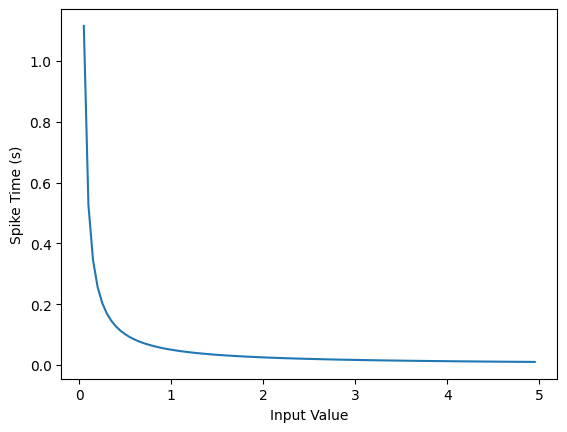

In [335]:
raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()

The smaller the value, the later the spike occurs with exponential dependence.

The vector `spike_times` contains the time at which spikes are triggered, rather than a sparse tensor that contains the spikes themselves (1's and 0's).
When running an SNN simulation, we need the 1/0 representation to obtain all of the advantages of using spikes.
This whole process can be automated using `spikegen.latency`, where we pass a minibatch from the MNIST dataset in `data_it`:

In [336]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)

Some of the arguments include:

* `tau`:  the RC time constant of the circuit. By default, the input features are treated as a constant current injected into an RC circuit. A higher ``tau`` will induce slower firing.
* `threshold`: the membrane potential firing threshold. Input values below this threshold do not have a closed-form solution, as the input current is insufficient to drive the membrane up to the threshold. All values below the threshold are clipped and assigned to the final time step.

#### 2.3.1 Raster plot

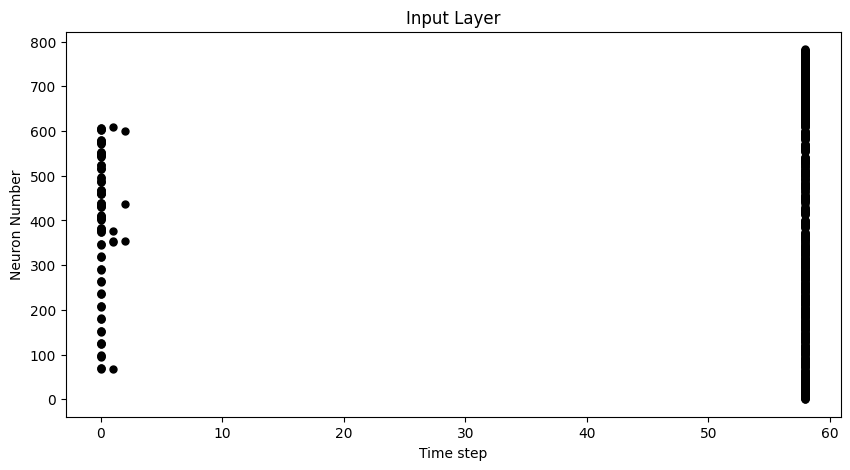

In [337]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

# optional save
# fig.savefig('destination_path.png', format='png', dpi=300)

To make sense of the raster plot, note that high intensity features fire first, whereas low intensity features fire last:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_5_latencyraster.png?raw=true' width="800">
</center>

The logarithmic code coupled with the lack of diverse input values (i.e., the lack of midtone/grayscale features) causes significant clustering in two areas of the plot.
The bright pixels induce firing at the start of the run, and the dark pixels at the end.
We can increase `tau` to slow down the spike times, or linearize the spike times by setting the optional argument `linear=True`.

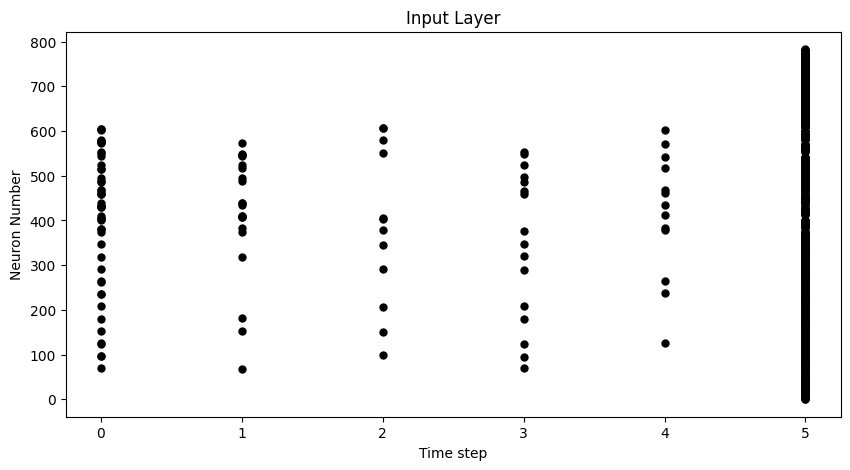

In [338]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

The spread of firing times is much more evenly distributed now. This is achieved by linearizing the logarithmic equation according to the rules shown below. Unlike the RC model, there is no physical basis for the model. It's just simpler.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_6_latencylinear.png?raw=true' width="600">
</center>


But note how all firing occurs within the first ~5 time steps, whereas the simulation range is 100 time steps.
This indicates that we have a lot of redundant time steps doing nothing. This can be solved by either increasing `tau` to slow down the time constant, or setting the optional argument `normalize=True` to span the full range of `num_steps`.

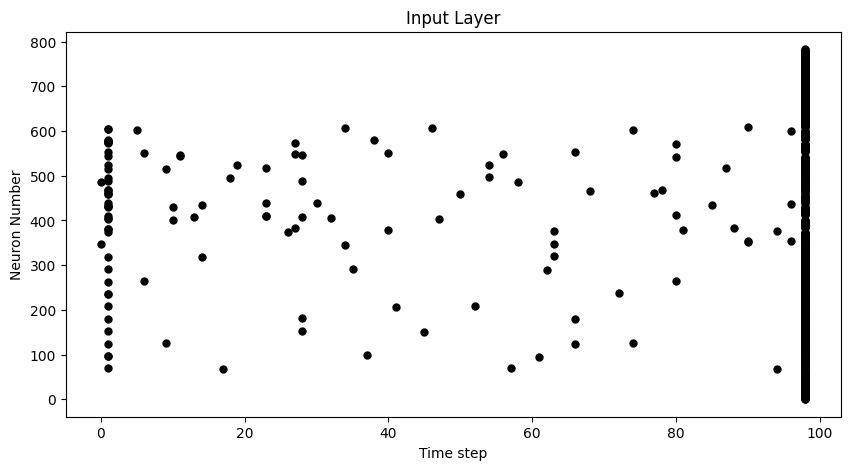

In [339]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

One major advantage of latency coding over rate coding is sparsity. If neurons are constrained to firing a maximum of once over the time course of interest, then this promotes low-power operation.

In the scenario shown above, a majority of the spikes occur at the final time step, where the input features fall below the threshold. In a sense, the dark background of the MNIST sample holds no useful information.

We can remove these redundant features by setting `clip=True`.

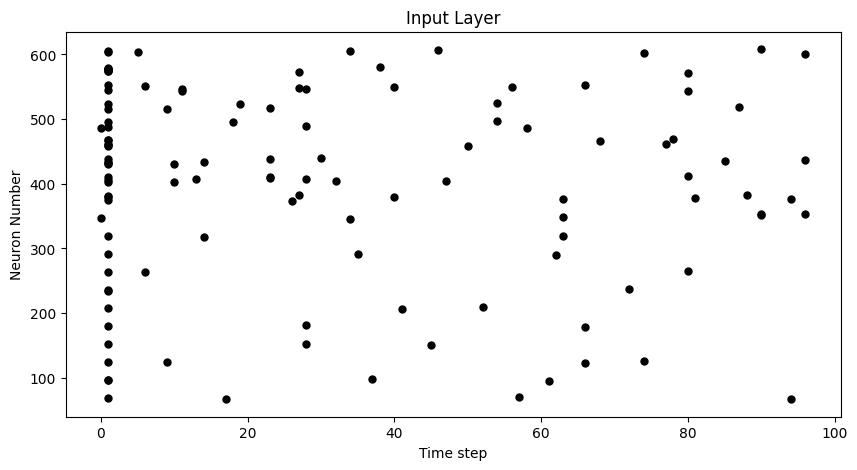

In [340]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              clip=True, normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

That looks much better!

#### 2.3.2 Animation
We will run the exact same code block as before to create an animation.

In [341]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


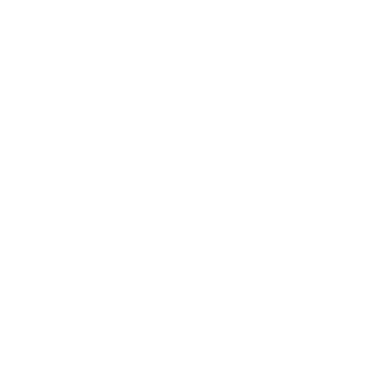

In [342]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())

This animation is obviously much tougher to make out in video form, but a keen eye will be able to catch a glimpse of the initial frame where most of the spikes occur.
Index into the corresponding target value to check its value.

In [343]:
# Save output: .gif, .mp4 etc.
# anim.save("mnist_latency.gif")

In [344]:
print(targets_it[0])

tensor(6)


That's it for the `spikegen.latency` function. Further information [can be found in the documentation here](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html).

### 2.4 Delta Modulation
There are theories that the retina is adaptive: it will only process information when there is something new to process. If there is no change in your field of view, then your photoreceptor cells are  less prone to firing.

That is to say: **biology is event-driven**. Neurons thrive on change.

As a nifty example, a few researchers have dedicated their lives to designing retina-inspired image sensors, for example, the [Dynamic Vision Sensor](https://ieeexplore.ieee.org/abstract/document/7128412/). Although [the attached link is from over a decade ago, the work in this video](https://www.youtube.com/watch?v=6eOM15U_t1M&ab_channel=TobiDelbruck) was ahead of its time.

Delta modulation is based on event-driven spiking. The `snntorch.delta` function accepts a time-series tensor as input. It takes the difference between each subsequent feature across all time steps. By default, if the difference is both *positive* and *greater than the threshold $V_{thr}$*, a spike is generated:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_7_delta.png?raw=true' width="600">
</center>

To illustrate, let's first come up with a contrived example where we create our own input tensor.

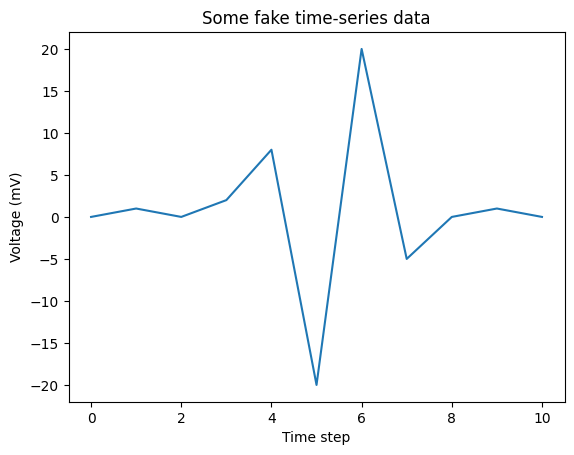

In [345]:
# Create a tensor with some fake time-series data
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# Plot the tensor
plt.plot(data)

plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

Pass the above tensor into the `spikegen.delta` function, with an arbitrarily selected `threshold=4`:

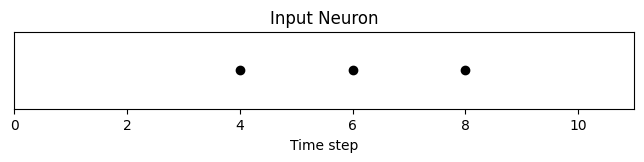

In [346]:
# Convert data
spike_data = spikegen.delta(data, threshold=4)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

There are three time steps where the difference between $data[T]$ and $data[T+1]$ is greater than or equal to $V_{thr}=4$. This means there are three *on-spikes*.

The large dip to $-20$ has not been captured above. If negative swings have importance in your data, you can enable the optional argument `off_spike=True`.

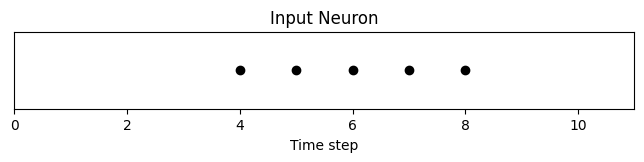

In [347]:
# Convert data
spike_data = spikegen.delta(data, threshold=4, off_spike=True)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

We've generated additional spikes, but this isn't actually the full picture!

Printing out the tensor will show the presence of "off-spikes" which take on a value of `-1`.

In [348]:
print(spike_data)

tensor([ 0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  1.,  0.,  0.])


While `spikegen.delta` has only been demonstrated on a fake sample of data, its true use is to compress time-series data by only generating spikes for sufficiently large changes/events.

That wraps up the three main spike conversion functions! There are still additional features to each of the three conversion techniques that have not been detailed in this tutorial. In particular, we have only looked at encoding input data; we have not considered how we might encode targets, and when that is necessary. We recommend [referring to the documentation for a deeper dive](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html).

# LIF



In [349]:
from snntorch import spikeplot as splt
from snntorch import spikegen



neuronal parameters



In [350]:
# set neuronal parameters
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t/tau)

print(f"The decay rate is: {beta:.3f}")

The decay rate is: 0.819


leaky_integrate_and_fire

In [351]:
lif1 = snn.Leaky(beta=0.8)

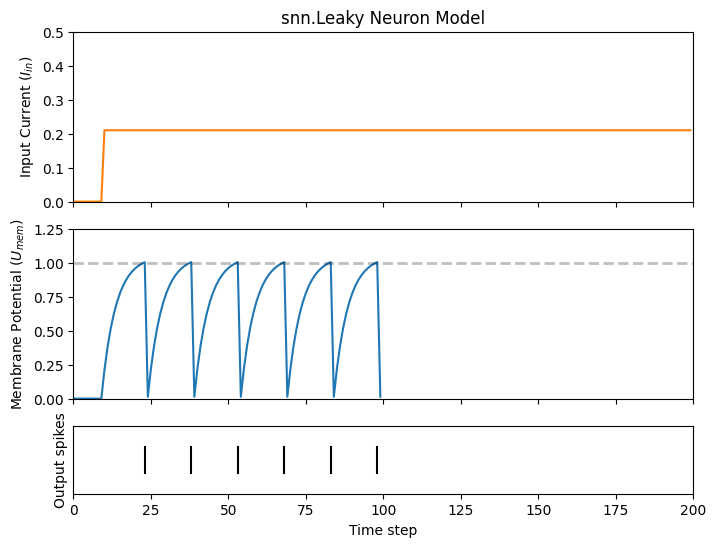

In [352]:
# Small step current input
w=0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  spk, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
                 title="snn.Leaky Neuron Model")


Here we are emulating a LIF neuron. it's identical to snn.Leaky

In [353]:
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = beta * mem + w*x - spk*threshold
  return spk, mem

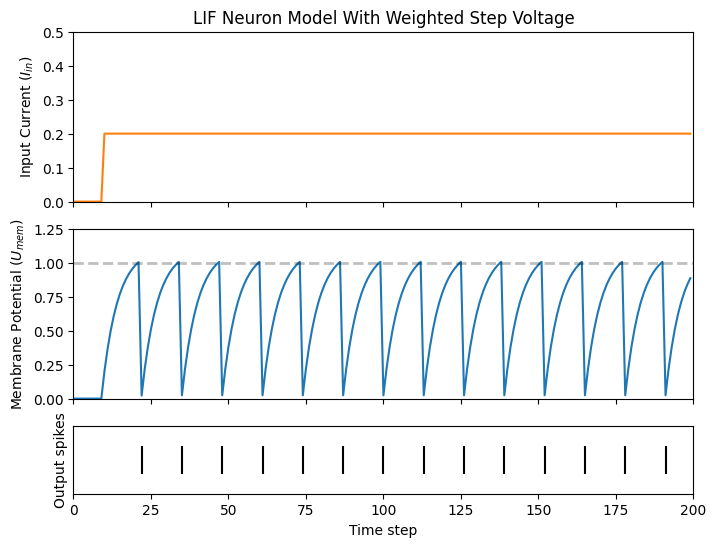

In [354]:
num_steps = 200

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron parameters
w = 0.4
beta = 0.819

# neuron simulation
for step in range(num_steps):
  spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1,ylim_max1=0.5,
                 title="LIF Neuron Model With Weighted Step Voltage")

As you can see the snn.Leaky() is identical to leaky_integrate_and_fire() you will be using leaky_integrate_and_fire()'s opration on the fpga to emulate  LIF.

#  Define the Network an

In [355]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [356]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

#  Training the SNN

##reimporting the dataset


In [357]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [358]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

In [359]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

##  Accuracy Metric
Below is a function that takes a batch of data, counts up all the spikes from each neuron (i.e., a rate code over the simulation time), and compares the index of the highest count with the actual target. If they match, then the network correctly predicted the target.

In [360]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")


##  Loss Definition
The `nn.CrossEntropyLoss` function in PyTorch automatically handles taking the softmax of the output layer as well as generating a loss at the output.

In [361]:
loss = nn.CrossEntropyLoss()

## Optimizer
Adam is a robust optimizer that performs well on recurrent networks, so let's use that with a learning rate of $5\times10^{-4}$.

In [362]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

## One Iteration of Training
Take the first batch of data and load it onto CUDA if available.

In [363]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

Flatten the input data to a vector of size $784$ and pass it into the network.

In [364]:
spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())

torch.Size([25, 128, 10])


The recording of the membrane potential is taken across:
* 25 time steps
* 128 samples of data
* 10 output neurons

We wish to calculate the loss at every time step, and sum these up together, as per Equation $(10)$:

In [365]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 62.507


The loss is quite large, because it is summed over 25 time steps. The accuracy is also bad (it should be roughly around 10%) as the network is untrained:

In [366]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 10.94%


A single weight update is applied to the network as follows:

In [367]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

Now, re-run the loss calculation and accuracy after a single iteration:

In [368]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 49.540
Train set accuracy for a single minibatch: 30.47%


After only one iteration, the loss should have decreased and accuracy should have increased. Note how membrane potential is used to calculate the cross entropy
loss, and spike count is used for the measure of accuracy. It is also possible to use the spike count in the loss ([see Tutorial 6](https://snntorch.readthedocs.io/en/latest/tutorials/index.html))

## 7.5 Training Loop

Let's combine everything into a training loop. We will train for one epoch (though feel free to increase `num_epochs`), exposing our network to each sample of data once.

In [369]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 51.22
Test Set Loss: 48.53
Train set accuracy for a single minibatch: 39.84%
Test set accuracy for a single minibatch: 30.47%


Epoch 0, Iteration 50
Train Set Loss: 11.22
Test Set Loss: 12.14
Train set accuracy for a single minibatch: 91.41%
Test set accuracy for a single minibatch: 88.28%


Epoch 0, Iteration 100
Train Set Loss: 7.95
Test Set Loss: 8.06
Train set accuracy for a single minibatch: 92.97%
Test set accuracy for a single minibatch: 92.19%


Epoch 0, Iteration 150
Train Set Loss: 12.04
Test Set Loss: 5.66
Train set accuracy for a single minibatch: 85.94%
Test set accuracy for a single minibatch: 92.19%


Epoch 0, Iteration 200
Train Set Loss: 10.63
Test Set Loss: 6.32
Train set accuracy for a single minibatch: 89.06%
Test set accuracy for a single minibatch: 93.75%


Epoch 0, Iteration 250
Train Set Loss: 8.96
Test Set Loss: 8.37
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 93.75%


Epoch 0

# Traning Results
##  Plot Training/Test Loss

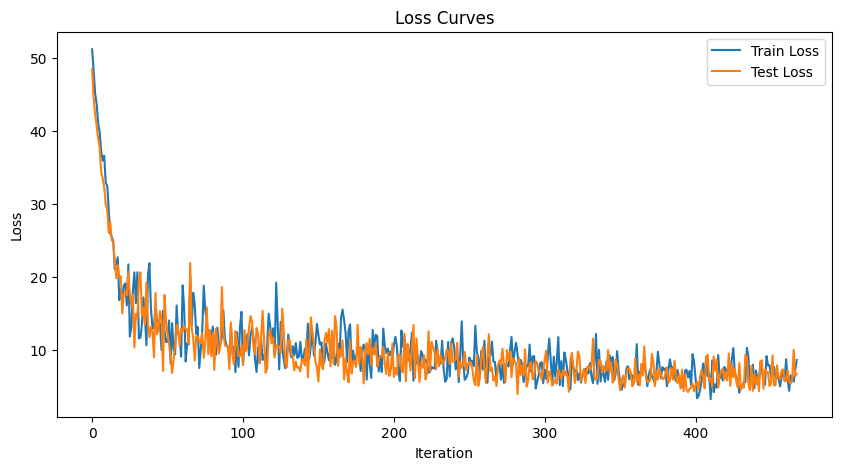

In [370]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

The loss curves are noisy because the losses are tracked at every iteration, rather than averaging across multiple iterations.

#Inferance

## Test Set Accuracy
This function iterates over all minibatches to obtain a measure of accuracy over the full 10,000 samples in the test set.

In [371]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9097/10000
Test Set Accuracy: 90.97%


## visulize infence

In [395]:
# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

In [396]:
# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

Create an input spike train to pass to the network. There are 200 time steps to simulate across 784 input neurons, i.e., the input originally has dimensions of $200 \times 784$. However, neural nets typically process data in minibatches. snnTorch uses time-first dimensionality:

[$time \times batch\_size \times feature\_dimensions$]

So 'unsqueeze' the input along `dim=1` to indicate 'one batch' of data. The dimensions of this input tensor must be 200 $\times$ 1 $\times$ 784:

In [397]:
spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")

Dimensions of spk_in: torch.Size([200, 1, 784])


Now it's finally time to run a full simulation.
An intuitive way to think about how PyTorch and snnTorch work together is that PyTorch routes the neurons together, and snnTorch loads the results into spiking neuron models. In terms of coding up a network, these spiking neurons can be treated like time-varying activation functions.

Here is a sequential account of what's going on:

*  The $i^{th}$ input from `spk_in` to the $j^{th}$ neuron is weighted by the parameters initialized in `nn.Linear`: $X_{i} \times W_{ij}$
* This generates the input current term from Equation $(10)$, contributing to $U[t+1]$ of the spiking neuron
* If $U[t+1] > U_{\rm thr}$, then a spike is triggered from this neuron
* This spike is weighted by the second layer weight, and the above process is repeated for all inputs, weights, and neurons.
* If there is no spike, then nothing is passed to the post-synaptic neuron.

The only difference from our simulations thus far is that we are now scaling the input current with a weight generated by `nn.Linear`, rather than manually setting $W$ ourselves.

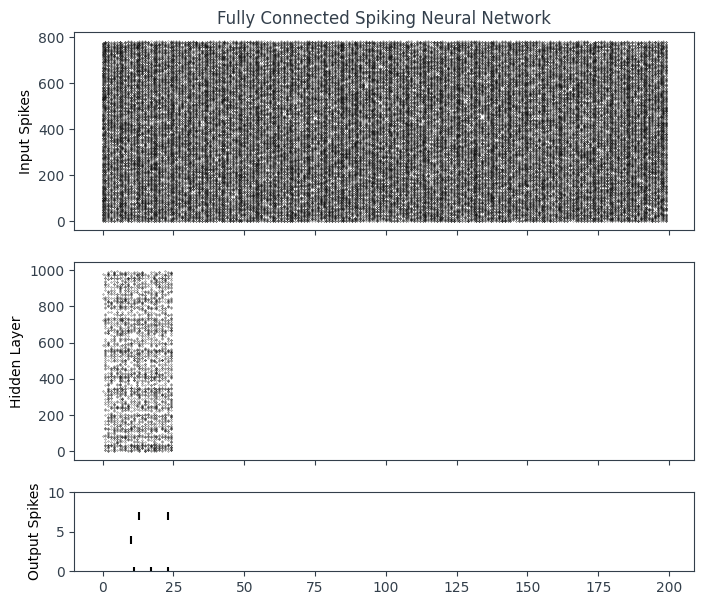

In [398]:
# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

> If you run into errors, then try re-initializing your networks and parameters.


At this stage, the spikes don't have any real meaning. The inputs and weights are all randomly initialized, and no training has taken place. But the spikes  should appear to be propagating from the first layer through to the output. If you are not seeing any spikes, then you might have been unlucky in the weight initialization lottery - you might want to try re-running the last four code-blocks.

`spikeplot.spike_count` can create a spike counter of the output layer. The following animation will take some time to generate. <br>

> Note: if you are running the notebook locally on your desktop, please uncomment the line below and modify the path to your ffmpeg.exe



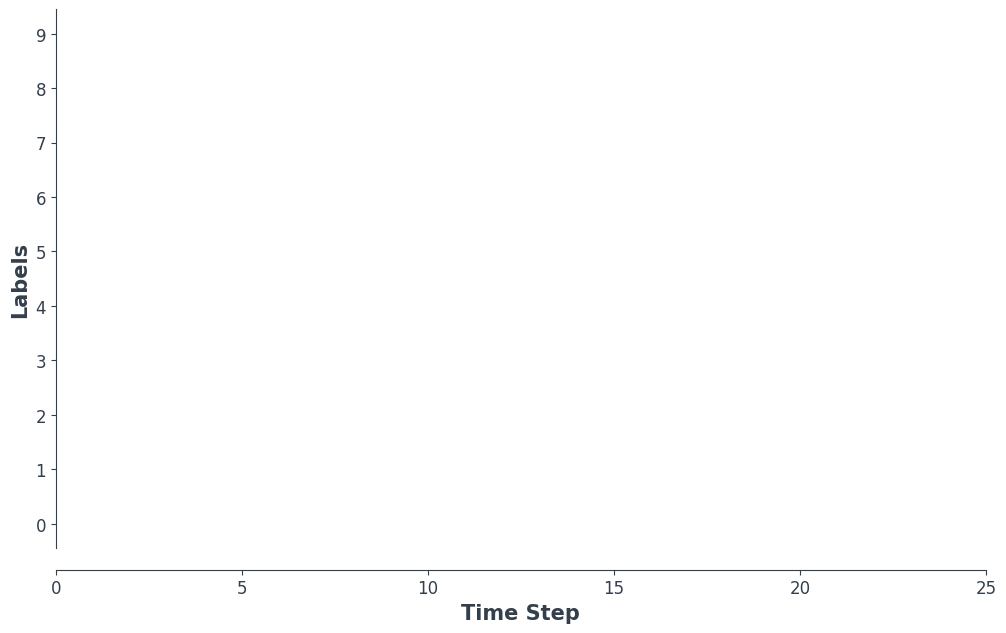

In [399]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

`spikeplot.traces` lets you visualize the membrane potential traces. We will plot 9 out of 10 output neurons.
Compare it to the animation and raster plot above to see if you can match the traces to the neuron.

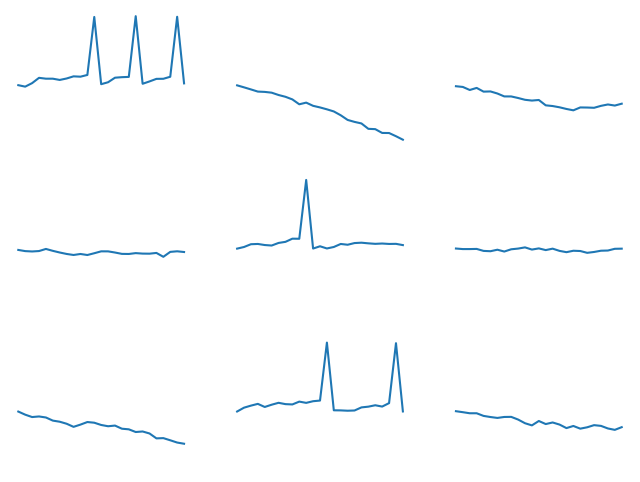

In [400]:
# plot membrane potential traces
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf()
fig.set_size_inches(8, 6)